# Классификация текстов с использованием Наивного Байесовского Классификатора

### Выполнила: Елисейкина Анастасия

In [72]:
import pandas as pd
import numpy as np

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_validate

import warnings
warnings.filterwarnings('ignore')

## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [18]:
df = pd.read_csv('data/spam_or_not_spam.csv')
df

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0
...,...,...
2995,abc s good morning america ranks it the NUMBE...,1
2996,hyperlink hyperlink hyperlink let mortgage le...,1
2997,thank you for shopping with us gifts for all ...,1
2998,the famous ebay marketing e course learn to s...,1


In [3]:
df.label.value_counts()

0    2500
1     500
Name: label, dtype: int64

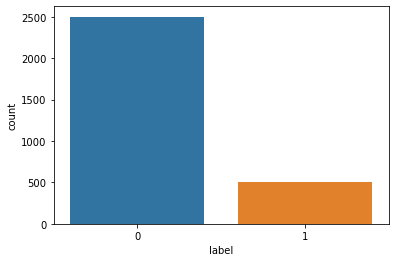

In [9]:
# визуализируйте результат: ваш код здесь
sns.countplot(df.label);

**Вывод:** Классы несбалансированы. Тех писем, которые не являются спамом - значительно больше.

## Задание 2 (2 балла)

Вам необходимо предобработать ваши данные и перевести их в векторный вид. Подгрузим необходимый модуль:

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

Замените все пустоты (пустые строки) в данных на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [19]:
df.dropna(axis=0, how='any', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2999 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   2999 non-null   object
 1   label   2999 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 70.3+ KB


Переводим данные в векторный вид:

In [46]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df["email"])
X = X.toarray()

Определите, сколько теперь признаков в нашем наборе данных:

In [50]:
X.shape[1]

34116

## Задание 3 (2 балла)

Определите целевую переменную и признаки:

In [51]:
y = df['label']

Разделите выборку на обучающую и тестовую, размер тестовой выборки возьмите как 0.25, параметр random_state определите со значением 42:

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [55]:
y_test.mean()

0.164

## Задание 4 (3 балла)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

In [58]:
CompNB = ComplementNB(alpha=0.01)
CompNB.fit(X_train, y_train)

y_train_pred = CompNB.predict(X_train)
y_test_pred = CompNB.predict(X_test)

Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [77]:
#метрики для тестовой выборки
print('Accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
#Рассчитываем precision
print('Precision: {:.3f}'.format(metrics.precision_score(y_test, y_test_pred)))
#Рассчитываем recall
print('Recall: {:.3f}'.format(metrics.recall_score(y_test, y_test_pred)))

Accuracy: 0.995
Precision: 0.984
Recall: 0.984


**Вывод:** На тестовой выборке модель показывает очень высокие метрики, что говорит о высоком качестве модели.

Нарисуйте ROC-кривую:

LogisticRegression: ROC AUC=0.987


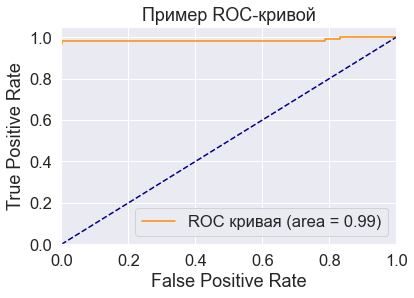

In [64]:
# получаем предказания
lr_probs = CompNB.predict_proba(X_test)
# сохраняем вероятности только для положительного исхода
lr_probs = lr_probs[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y_test, lr_probs)
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

In [76]:
scores_dict = {}

for alph in np.arange(0, 1, 0.1):
    CompNB = ComplementNB(alpha=alph)
    scores = cross_validate(CompNB, X, y, cv = 5,
                        scoring = ('accuracy', 'precision', 'recall'),
                        return_train_score = True)
    scores_dict[alph] = scores['test_accuracy']

scores_dict

{0.0: array([0.97666667, 0.965     , 0.94666667, 0.94833333, 0.96661102]),
 0.1: array([0.97666667, 0.97833333, 0.99      , 0.98      , 0.98664441]),
 0.2: array([0.97666667, 0.98      , 0.98833333, 0.98      , 0.98163606]),
 0.30000000000000004: array([0.97333333, 0.98      , 0.98666667, 0.97666667, 0.97829716]),
 0.4: array([0.975     , 0.98      , 0.985     , 0.97833333, 0.97662771]),
 0.5: array([0.97833333, 0.98      , 0.985     , 0.97833333, 0.98330551]),
 0.6000000000000001: array([0.97833333, 0.98      , 0.98333333, 0.98      , 0.98163606]),
 0.7000000000000001: array([0.98166667, 0.98      , 0.98333333, 0.97833333, 0.98330551]),
 0.8: array([0.98166667, 0.98      , 0.98166667, 0.97166667, 0.98497496]),
 0.9: array([0.98166667, 0.98      , 0.98      , 0.97333333, 0.98497496])}

**Вывод:** Качество модели становится выше при любом значении альфа, отличном от нуля. При любых других значениях качество модели не изменяется.